In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions
import features_aug

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [4]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data = data[data.detected == 1]
data.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
222,13,60532.3019,2,24.529644,1.046373,1,3.790512,0
223,13,60532.3097,1,23.404964,0.992504,1,3.675929,0
224,13,60532.3173,3,36.069386,1.568371,1,3.875155,0
225,13,60532.3282,4,42.765503,2.305008,1,3.938479,0
226,13,60532.3392,5,36.567162,5.439748,1,3.987288,0


In [5]:
object_ids = np.unique(data.object_id)

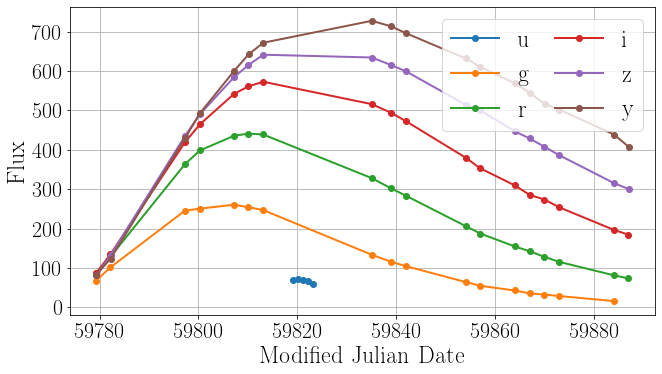

In [5]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

In [7]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

aug_model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)

from sklearn.preprocessing import StandardScaler
t_train = anobject_train['mjd'].values
ss_t = StandardScaler().fit(np.array(t_train).reshape((-1, 1)))
flux_train = anobject_train['flux'].values
X_train = aug_model.get_features(t_train, anobject_train['passband'].values, ss_t)
ss_x = StandardScaler().fit(X_train)
X_train_ss = ss_x.transform(X_train)
ss_y = StandardScaler().fit(flux_train.reshape((-1, 1)))
y_train_ss = ss_y.transform(flux_train.reshape((-1, 1)))

t_test = anobject_test['mjd'].values
flux_test = anobject_train['flux'].values
X_test = aug_model.get_features(t_test, anobject_test['passband'].values, ss_t)
X_test_ss = ss_x.transform(X_test)
y_test_ss = ss_y.transform(flux_test.reshape((-1, 1)))

reg = features_aug.FitNNRegressor(n_hidden=100, n_epochs=100, batch_size=1, optimizer='SGD', lr=0.01)
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred['flux'] = np.maximum(res, np.zeros(len(res)))

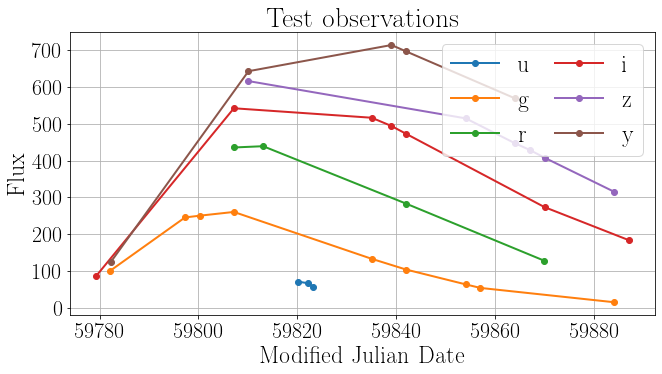

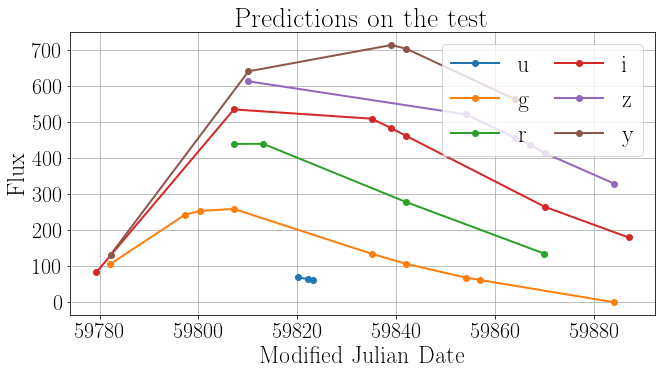

In [8]:
aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

In [9]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  6.72226585440215
MAE:  5.63476824599322
RSE:  0.03195625569174147
RAE:  0.03008702736935427
MAPE:  5.5657699053638705


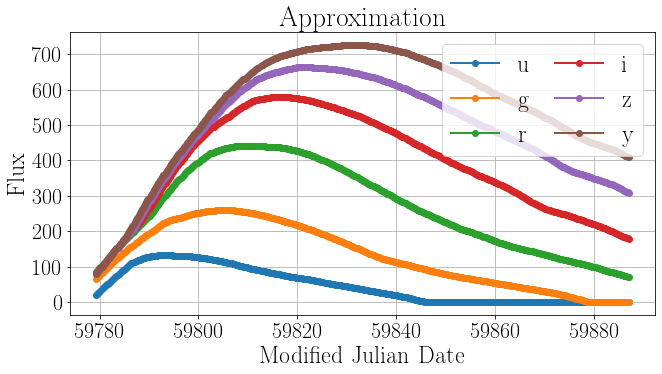

In [10]:
approx_object = aug_functions.create_approx_object(anobject)
t = approx_object.mjd.values
X = aug_model.get_features(t, approx_object['passband'].values, ss_t)
X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = np.maximum(res, np.zeros(len(res)))
aug_functions.plot_light_curves(approx_object, "Approximation")

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [12]:
from tqdm import tqdm
from tqdm import tqdm_notebook

def test_model(n_hidden=10, n_epochs=100, batch_size=1, lr=0.01, optimizer='SGD'):
    metrics = []
    index = np.random.choice(len(object_ids), size=len(object_ids) // 10)
    for i in index:
        good_id = object_ids[i]

        # get an object
        anobject = aug_functions.get_object(data, good_id)

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        t_train = anobject_train['mjd'].values
        ss_t = StandardScaler().fit(np.array(t_train).reshape((-1, 1)))
        flux_train = anobject_train['flux'].values
        X_train = aug_model.get_features(t_train, anobject_train['passband'].values, ss_t)
        ss_x = StandardScaler().fit(X_train)
        X_train_ss = ss_x.transform(X_train)
        ss_y = StandardScaler().fit(flux_train.reshape((-1, 1)))
        y_train_ss = ss_y.transform(flux_train.reshape((-1, 1)))

        t_test = anobject_test['mjd'].values
        flux_test = anobject_train['flux'].values
        X_test = aug_model.get_features(t_test, anobject_test['passband'].values, ss_t)
        X_test_ss = ss_x.transform(X_test)
        y_test_ss = ss_y.transform(flux_test.reshape((-1, 1)))

        # fit a regression model to approximate light curves
        reg = features_aug.FitNNRegressor(n_hidden=n_hidden, 
                                                    n_epochs=n_epochs, 
                                                    batch_size=batch_size, 
                                                    lr=lr, 
                                                    optimizer=optimizer)
        reg.fit(X_train_ss, y_train_ss)

        # predict flux for unseen observations
        anobject_test_pred = anobject_test.copy()
        res = ss_y.inverse_transform(reg.predict(X_test_ss))
        anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))

        mape = mean_absolute_percentage_error(anobject_test['flux'].values, 
                                              anobject_test_pred['flux'].values)
        metrics.append(mape)
    return np.mean(metrics)

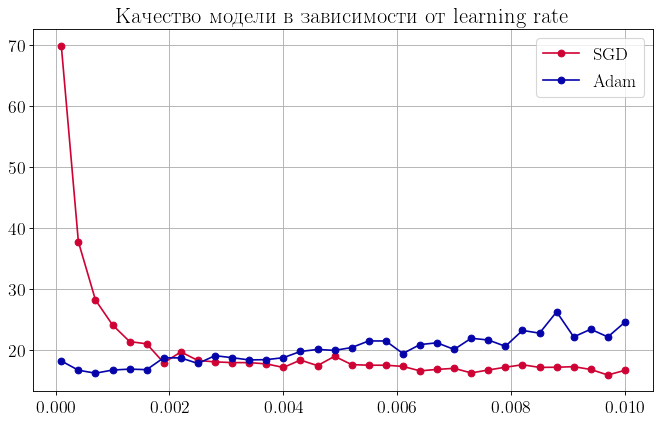

In [40]:
learning_rate = np.arange(0.0001, 0.0101, 0.0003)
sgd_metrics = []
adam_metrics = []
sgd_lr = []
adam_lr = []

for lr in tqdm_notebook(learning_rate):
    try:
        sgd_mape = test_model(n_hidden=100, optimizer='SGD', lr=lr)
        sgd_metrics.append(sgd_mape)
        sgd_lr.append(lr)

        adam_mape = test_model(n_hidden=100, optimizer='Adam', lr=lr)
        adam_metrics.append(adam_mape)
        adam_lr.append(lr)
    except:
        continue
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от learning rate", fontsize=20)
plt.plot(sgd_lr, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(adam_lr, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_lr_fe.pdf")    

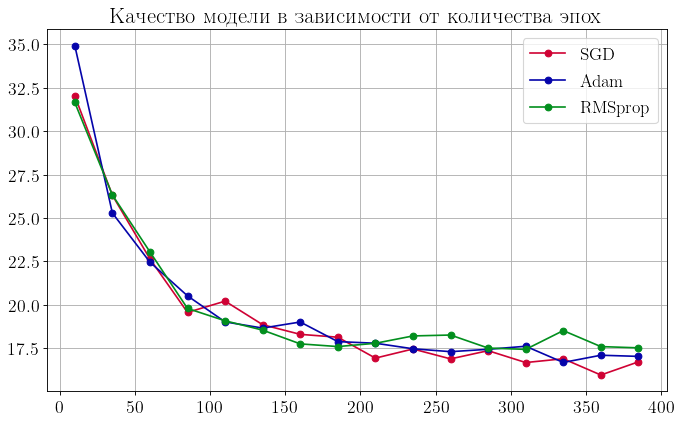

In [13]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

epochs_range = np.arange(10, 201, 25)
for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='Adam', lr=0.0007)
    adam_metrics.append(adam_mape)
    sgd_mape = test_model(n_hidden=80, n_epochs=epochs, optimizer='SGD', lr=0.01)
    sgd_metrics.append(sgd_mape)
    RMSprop_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='RMSprop', lr=0.0007)
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_fe.pdf")

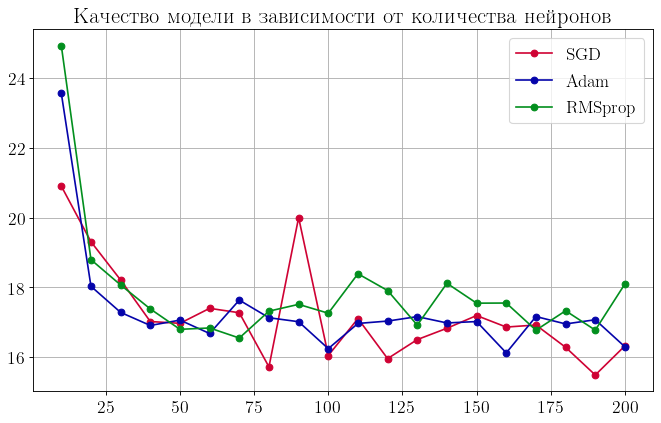

In [52]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

neurons_range = np.arange(10, 201, 10)
for n_hidden in tqdm_notebook(neurons_range):
    sgd_mape = test_model(n_hidden, optimizer='SGD')
    sgd_metrics.append(sgd_mape)
    adam_mape = test_model(n_hidden, optimizer='Adam', lr=0.0007)
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden, optimizer='RMSprop', lr=0.0007)
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.plot(neurons_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(neurons_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_fe.pdf")

In [18]:
anobject = aug_functions.get_object(data, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err = model.predict(anobject_test['mjd'].values, 
                                    anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

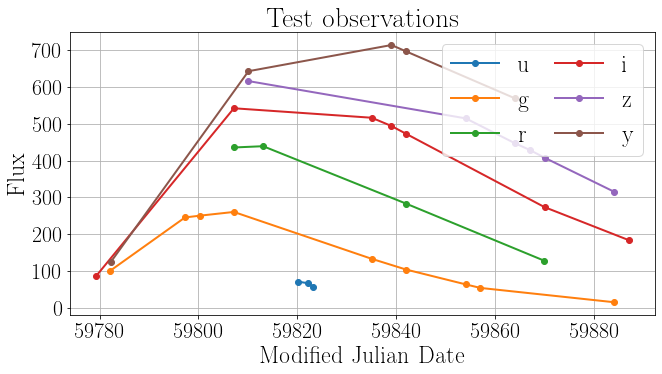

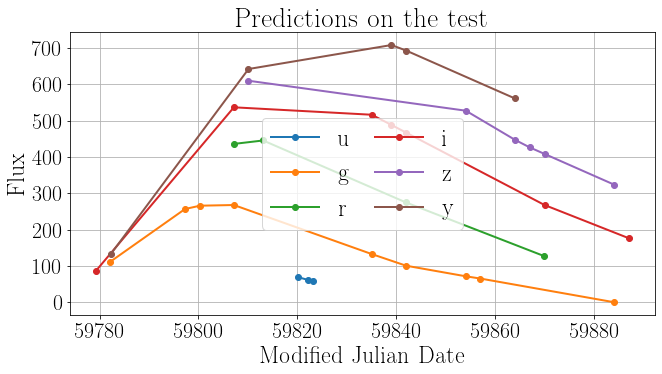

In [19]:
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)

aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

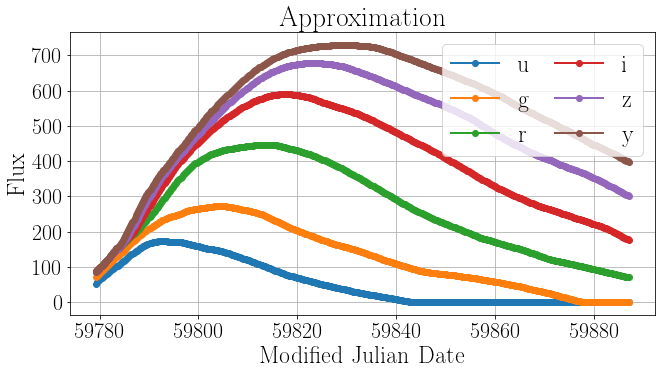

In [20]:
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [91]:
from tqdm import tqdm
from tqdm import tqdm_notebook

metrics = []
for good_id in tqdm_notebook(object_ids):
    # get an object
    anobject = aug_functions.get_object(data, good_id)

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # fit augmentation model
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)
    anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                                   flux_pred, anobject_test['passband'].values)

    # calc metrics
    metrics.append(utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                           anobject_test_pred['flux'].values))

df_metrics = pd.DataFrame(data=metrics, columns=["RMSE", "MAE", "RSE", "RAE", "MAPE"])
df_metrics.mean()

RMSE    20.581037
MAE     12.217686
RSE      0.319593
RAE      0.284479
MAPE    18.001321
dtype: float64